In [101]:
"""
Plot to show fitness over generations
"""

import matplotlib.pyplot as plt

def plot(results, param, fitness_type, jitter=0):
    
    plt.figure(figsize=(12, 10))
    plt.title(f"Comparing {param}", fontsize=22)
    plt.xlabel("Generation", fontsize=20)
    plt.ylabel(f"{fitness_type}", fontsize=20)
    
    param_values = []
    color_map = {}
    color_legend = {}

    for result in results:

        if result[param] not in param_values:
            param_values.append(result[param])
        
        best_fitness = result[fitness_type]
        generations = range(len(best_fitness))
        
        if jitter:
            jitter_amount = random.uniform(-jitter, jitter)
            best_fitness_j = [f + jitter_amount for f in best_fitness]
        else:
            best_fitness_j = best_fitness

        if result[param] == param_values[0]:
            colour = "blue"
        else:
            colour = "green"
            
        if colour not in color_legend:
                if callable(result[param]):
                    color_legend[colour] = f"{param} = {result[param].__name__}"
                else:
                    color_legend[colour] = f"{param} = {result[param]}"

        plt.plot(generations, best_fitness_j, color=colour)

    legend_handles = [plt.Line2D([0], [0], color=color, label=label) for color, label in color_legend.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=18)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
        
    plt.grid(True)
    plt.show()
    

In [102]:
"""
Plot to show how strategy of any memory length makes a choice
"""

import networkx as nx

def binary_tree_plot(strategy):
    leaves = strategy[1:]
    num_leaf_nodes = len(leaves)
    tree_depth = int(math.log2(num_leaf_nodes))
    
    edge_labels = {}
    node_labels = {}
    node_colours = {}

    G = nx.DiGraph()

    node_count = 1
    G.add_node(node_count)
    node_labels[node_count] = ""
    node_colours[node_count] = "lightblue"
    node_count += 1
    
    for branch in range(1, tree_depth):
        for i in range(2**branch):
            G.add_node(node_count)
            node_labels[node_count] = ""
            node_colours[node_count] = "lightblue"
            node_count += 1

    leaf_nodes = []
    for leaf in leaves:
        G.add_node(node_count)
        node_labels[node_count] = "C" if leaf else "D"
        node_colours[node_count] = "springgreen" if leaf else "indianred"
        leaf_nodes.append(node_count)
        node_count += 1

    for node in range(1, 2**tree_depth):
        if node < 2**(tree_depth-1):  # Internal nodes
            G.add_edge(node, 2*node)
            edge_labels[(node, 2*node)] = "D"
            G.add_edge(node, 2*node + 1)
            edge_labels[(node, 2*node + 1)] = "C"
        else:  # Parent of leaf nodes
            G.add_edge(node, 2*node)
            G.add_edge(node, 2*node + 1)

    pos = {}
    x, y = 12, 8
    pos[1] = (x, y)
    
    width = 2*x
    for level in range(1, tree_depth + 1):
        y -= 2
        for i in range(2**level):
            node = (2**level) + i
            increment = width / (2**level + 1)
            x = (i + 1) * increment
            pos[node] = (x, y)

    plt.figure(figsize=(12, 8))

    node_sizes = [1000 if node not in leaf_nodes else 400 for node in G.nodes()]

    nx.draw(
        G,
        pos,
        labels=node_labels,
        node_color=[node_colours[node] for node in G.nodes()],
        node_size=node_sizes,
        with_labels=True,
        arrows=True
    )

    edge_labels_filtered = {k: v for k, v in edge_labels.items() if k[1] not in leaf_nodes}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_filtered, font_size=14)

    plt.show()
    

In [103]:
"""
UNCHANGED GENETIC ALGORITHM COMPONENTS
"""

always_cooperates = [1, 1, 1]                  
always_defects = [0, 0, 0]
tit_for_tat = [1, 0, 1]
fixed_strategies = [always_cooperates, always_defects, tit_for_tat]


import random

random.seed(214)

def random_pop(n, memory_length): # makes random prisoner strategies of specified memory length (with duplicate individuals)
    
    pop = []
    indices = list(range(1 + 2**memory_length))
    
    for individual in range(n):
        num_cooperations = random.randint(0, (1 + 2**memory_length))
        cooperation_indices = random.sample(indices, num_cooperations)
        pop.append([1 if index in cooperation_indices else 0 for index in indices])

    return pop


def strat(prisoner, seqSelf, seqOpp, memory_length): # return 1 for cooperate OR 0 for defect
    
    game_length = len(seqSelf)
    
    if game_length < memory_length: 
        
        if game_length == 0: # what to do on the first move
            return prisoner[0] # predefined first move

        else: # what to do before game is the length of the memory of the agents
            choice_remainders = list(range(2**(memory_length - game_length)))

            count = 0
            base = 1
            for i in range(game_length):
                base += (seqOpp[i] * (2**(memory_length - game_length)))
                count += 1

            choices = [base + remainder for remainder in choice_remainders]
            total_cooperations = sum(prisoner[choice] for choice in choices)

            if total_cooperations < 2**(memory_length - game_length - 1):
                return 0
            else:
                return 1

    else:
        count = 0
        move_index = 1
        while count < memory_length:
            move_index += (seqOpp[-memory_length + count] * (2**(memory_length - count - 1)))
            count += 1
        return prisoner[move_index]

    
import math

payoff_matrix = [[(3, 3), (0, 5)],
                 [(5, 0), (1, 1)]]

def iterated_dilemma(prisonerA, prisonerB, n):
    
    memoryA, memoryB = int(math.log2(len(prisonerA) - 1)), int(math.log2(len(prisonerB) - 1)) # memory length of each prisoner
    seqA, seqB = [], [] # sequence of moves for each prisoner
    payoffA, payoffB = 0, 0 # payoff for each prisoner

    for i in range(n): # number of iteration of the dilemma
        
        # move for each prisoner
        moveA = strat(prisonerA, seqA, seqB, memoryA)
        moveB = strat(prisonerB, seqB, seqA, memoryB)
        
        # adds the move to the sequence of previous moves for each prisoner
        seqA.append(moveA)
        seqB.append(moveB)
        
        # calculates once-off pay-off for each prisoner based on move
        if moveA and moveB:
            scoreA, scoreB =  payoff_matrix[0][0]
        elif moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[0][1]
        elif not moveA and moveB:
            scoreA, scoreB =  payoff_matrix[1][0]
        elif not moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[1][1]
        
        # adds once-off pay-off to total pay-off for each prisoner
        payoffA += scoreA
        payoffB += scoreB
        
    return payoffA, payoffB


def two_point_crossover(parent1, parent2):
    
    n = len(parent1)
    subset_length = (n-1)//4
    
    start_index = random.randint(1, n-subset_length)
    end_index = start_index + subset_length
    
    subset1a, subset1b, subset1c = parent1[:start_index], parent1[start_index:end_index], parent1[end_index:]
    subset2a, subset2b, subset2c = parent2[:start_index], parent2[start_index:end_index], parent2[end_index:]
    
    child1, child2 = [], []
    
    child1.extend(subset1a)
    child1.extend(subset2b) 
    child1.extend(subset1c)

    child2.extend(subset2a)
    child2.extend(subset1b)
    child2.extend(subset2c)
                
    return child1, child2

def mid_point_crossover(parent1, parent2):
    
    n = len(parent1)
    split_index = (n+1)//2
    
    subset1a, subset1b = parent1[:split_index], parent1[split_index:]
    subset2a, subset2b = parent2[:split_index], parent2[split_index:]
    
    child1, child2 = [], []
    
    child1.extend(subset1a)
    child1.extend(subset2b) 

    child2.extend(subset2a)
    child2.extend(subset1b)
                
    return child1, child2



def reverse_sequence_mutation(prisoner):
    
    n = len(prisoner)
    
    start_index = random.randint(0, n-2)
    end_index = random.randint(start_index, n-1)

    subset = prisoner[start_index:end_index]
    reverse_subset = subset[::-1]
    
    mutation = prisoner[:start_index] + reverse_subset + prisoner[end_index:]

    return mutation


def inverse_mutation(prisoner):
    
    n = len(prisoner)
    
    start_index = random.randint(0, n-2)
    end_index = random.randint(start_index, n-1)

    subset = prisoner[start_index:end_index]
    inverse_subset = [(choice + 1) % 2 for choice in subset]

    mutation = prisoner[:start_index] + inverse_subset + prisoner[end_index:]

    return mutation


In [106]:
"""
CHANGED GENETIC ALGORITHM COMPONENTS

• Co-evolutionary approach
"""


def fitness(prisoner, n, pop):
    
    opponents = random.sample(pop, len(pop)//10)
    
    sum_payoff = 0
    
    for opponent in opponents:
        payoff, opp_payoff = iterated_dilemma(prisoner, opponent, n)
        sum_payoff += payoff
                
    average_payoff = sum_payoff/len(opponents) # average payoff against fixed strategies
    expected_payoff = average_payoff/n # expected payoff for prisoner for any iteration
    return expected_payoff 

def tournament_selection(pop, n=20, k=2, tournament_size=4):
    
    selection = []
    
    for individual in range(k):
        candidates = random.sample(pop, tournament_size)
        best = max(candidates, key=lambda candidate: fitness(candidate, n, pop))
        selection.append(best)
        
    return tuple(selection)

def run_genetic_algorithm(population_size, num_iterations, memory_length, num_generations, crossover_function,
                          mutation_function, mutation_rate):
    
    # features to track
    gen_count = 0
    gen_counts = []
    gen_best_fitnesses = []
    gen_best_strategies = []
    gen_mean_fitnesses = []
    gen_min_fitnesses = []
    gen_times = []
    best_strategy = always_cooperates
    
    pop = random_pop(population_size, memory_length) # initialises population
    best_strategy = pop[0]
    best_fitness = fitness(best_strategy, num_iterations, pop)
        
    no_improvement_count = 0 # counter to stop the code if we get 5 generations without improvement
    prev_best_fitness = float('inf')
    prev_mean_fitness = float('inf')

    for generation in range(num_generations):
        
        start_time = time.time() # starts timer
        
        fitnesses = [fitness(prisoner, num_iterations, pop) for prisoner in pop] # calculates individuals fitnesses
        new_pop = []

        while len(new_pop) < population_size: # assigns new individuals to the population for next generation
            
            parent1, parent2 = tournament_selection(pop, num_iterations, 2, 4) # tournament selection for choosing parents
            
            # applying crossover operator to create children
            child1, child2 = crossover_function(parent1, parent2)
                
            # random chance of mutation
            if random.random() < mutation_rate:
                child1 = mutation_function(child1)
                    
            # independent random chance of the second child mutating        
            if random.random() < mutation_rate:
                child2 = mutation_function(child2)

            new_pop.append(child1)
            new_pop.append(child2)
                    
        # calculating results for the current generation
        gen_count = gen_count + 1
        gen_best_fitness = max(fitnesses)
        gen_best_strategy = pop[fitnesses.index(gen_best_fitness)]
        gen_mean_fitness = sum(fitnesses) / population_size
        gen_min_fitness = min(fitnesses)
        gen_time = time.time() - start_time # ends timer
        
        # updates best strategy if new best is found
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_strategy = pop[fitnesses.index(gen_best_fitness)]
        
        # adds results
        gen_counts.append(gen_count)
        gen_best_fitnesses.append(gen_best_fitness)
        gen_best_strategies.append(gen_best_strategy)
        gen_mean_fitnesses.append(gen_mean_fitness)
        gen_min_fitnesses.append(gen_min_fitness)
        gen_times.append(gen_time)
        
        # if theres no improvement of the best generation fitness
        if gen_best_fitness <= prev_best_fitness:
            no_improvement_count = no_improvement_count + 1
        else:
            no_improvement_count = 0
        
        # stops the evolution algorithm if no improvement in 5 generations
        if no_improvement_count >= 10:
            break

        prev_best_fitness = gen_best_fitness
        prev_mean_fitness = gen_mean_fitness
        
        pop = new_pop # assigns the new generation to be the current generation

    
    # dictionary for results
    implementation_data = {
        "gen_counts": gen_counts,
        "gen_best_fitnesses": gen_best_fitnesses,
        "gen_best_strategies": gen_best_strategies,
        "gen_mean_fitnesses": gen_mean_fitnesses,
        "gen_min_fitnesses": gen_min_fitnesses,
        "gen_compute_time": gen_times
    }
        
    return implementation_data, best_strategy, pop


In [107]:
"""
• Extend your representation (genotype) and compare the findings
"""

# DEFINING HYPERPARAMETERS TO BE USED

population_sizes = [100]
memory_lengths = [5]
crossover_operators = [two_point_crossover, mid_point_crossover]
mutation_operators = [reverse_sequence_mutation, inverse_mutation]
mutation_rates = [0.1, 0.25]

# GRID SEARCH ALL HYPERPARAMETER COMBINATIONS

results2 = []

for crossover_operator in crossover_operators:
    for mutation_operator in mutation_operators:
        for mutation_rate in mutation_rates:

            print("Crossover Operator =", crossover_operator.__name__, "\nMutation Operator =", mutation_operator.__name__, "\nMutation Rate =", mutation_rate)

            start_time = time.time()
            result, best_strategy, final_pop = run_genetic_algorithm(population_sizes[0], 40, memory_lengths[0], 40, crossover_operator, mutation_operator, mutation_rate)
            print("Best Strategy =", best_strategy, "\nFitness =", fitness(best_strategy, 40, final_pop), "\nTime Taken = ", round(time.time()-start_time), "seconds\n")

            results2.append({
                'strategy': best_strategy,
                'best fitness per generation': result['gen_best_fitnesses'],
                'mean fitness per generation': result['gen_mean_fitnesses'],
                'population_size': population_size,
                'memory_length': memory_length,
                'crossover': crossover_operator,
                'mutation': mutation_operator,
                'mutation rate': mutation_rate
            })
            

Crossover Operator = two_point_crossover 
Mutation Operator = reverse_sequence_mutation 
Mutation Rate = 0.1
Best Strategy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
Fitness = 1.1 
Time Taken =  45 seconds

Crossover Operator = two_point_crossover 
Mutation Operator = reverse_sequence_mutation 
Mutation Rate = 0.25
Best Strategy = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
Fitness = 1.7574999999999998 
Time Taken =  44 seconds

Crossover Operator = two_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.1
Best Strategy = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0] 
Fitness = 1.6375 
Time Taken =  45 seconds

Crossover Operator = two_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.25
Best Strategy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

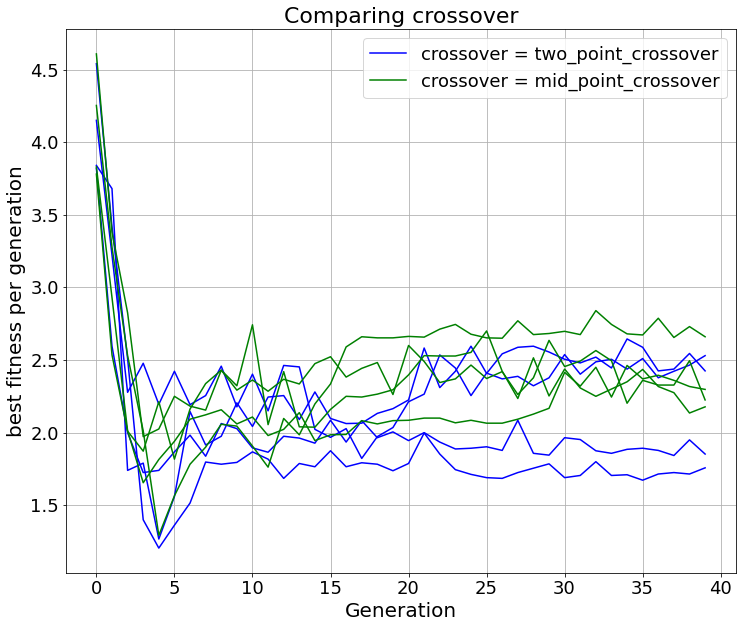

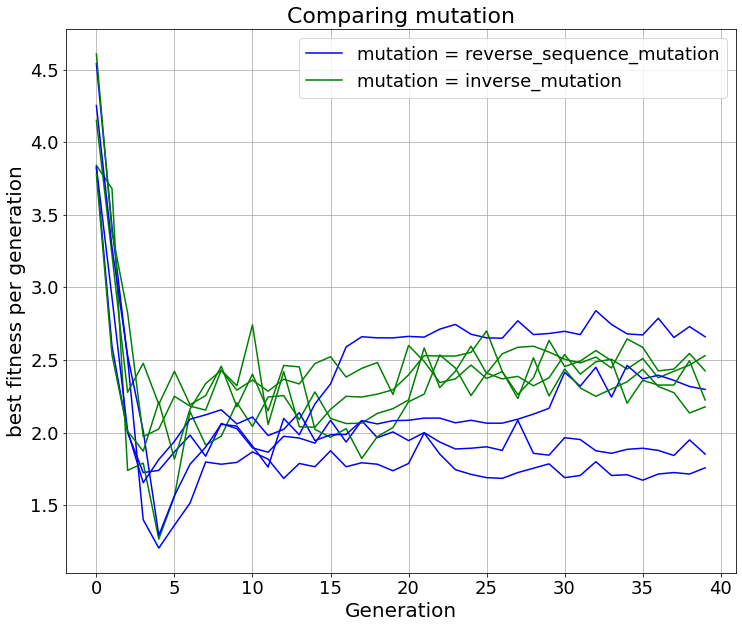

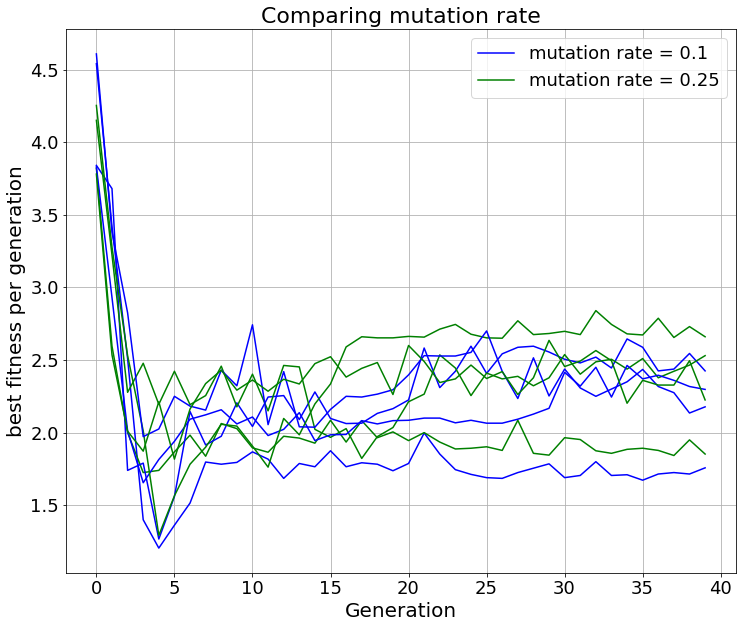

In [108]:
# Plotting best population fitness over generations

plot(results2, 'crossover', 'best fitness per generation')
plot(results2, 'mutation', 'best fitness per generation')
plot(results2, 'mutation rate', 'best fitness per generation')

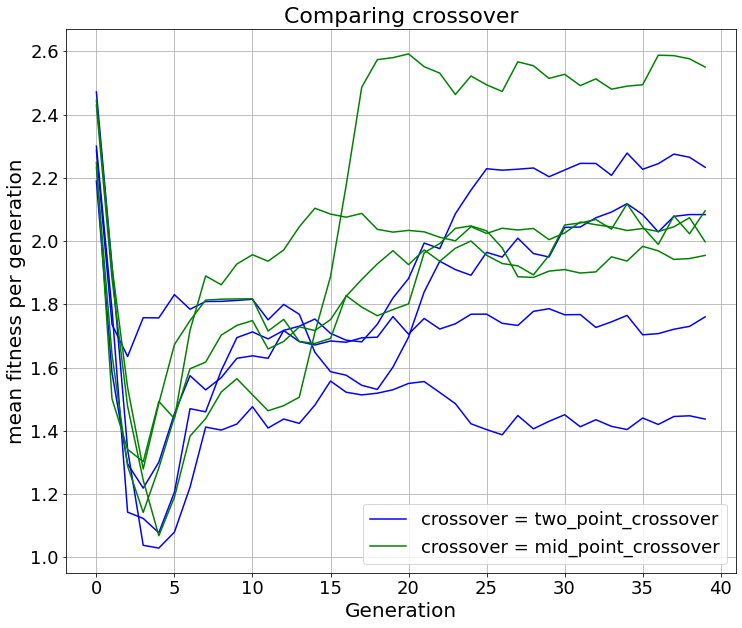

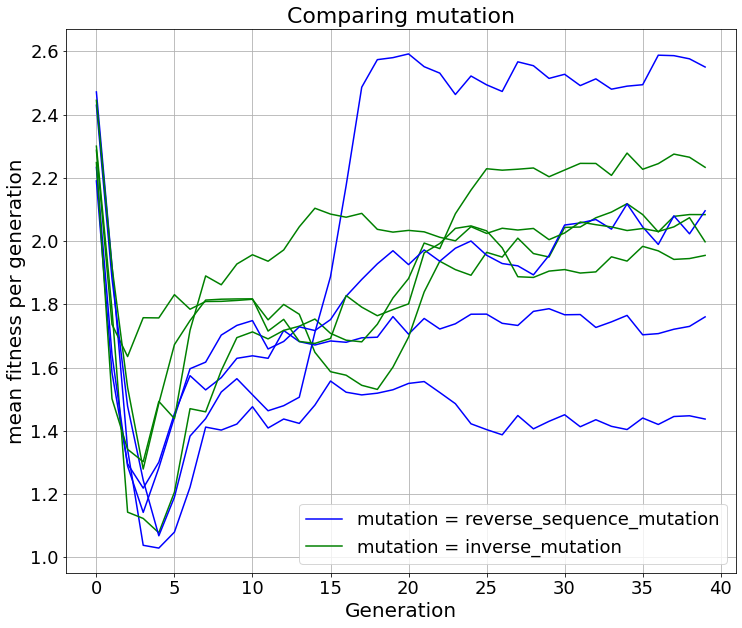

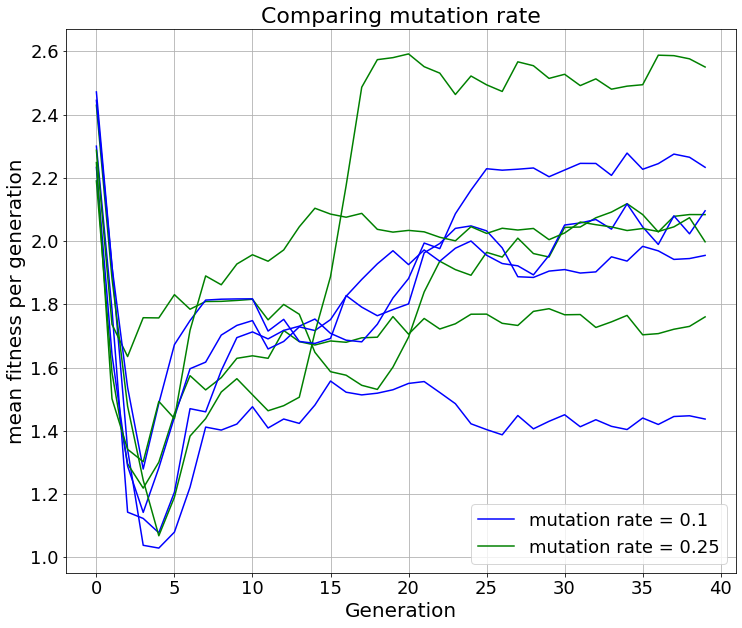

In [109]:
# Plotting mean population fitness over generations

plot(results2, 'crossover', 'mean fitness per generation')
plot(results2, 'mutation', 'mean fitness per generation')
plot(results2, 'mutation rate', 'mean fitness per generation')

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


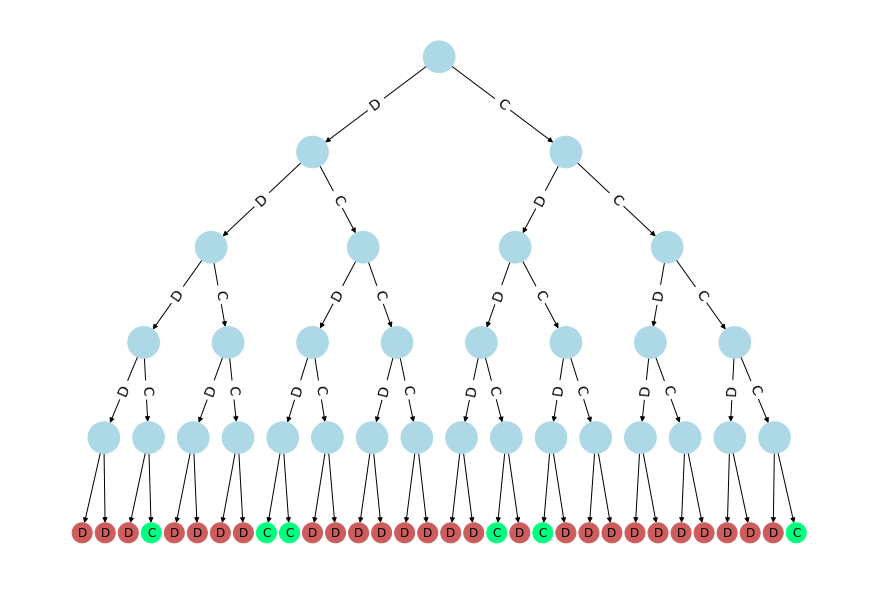

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


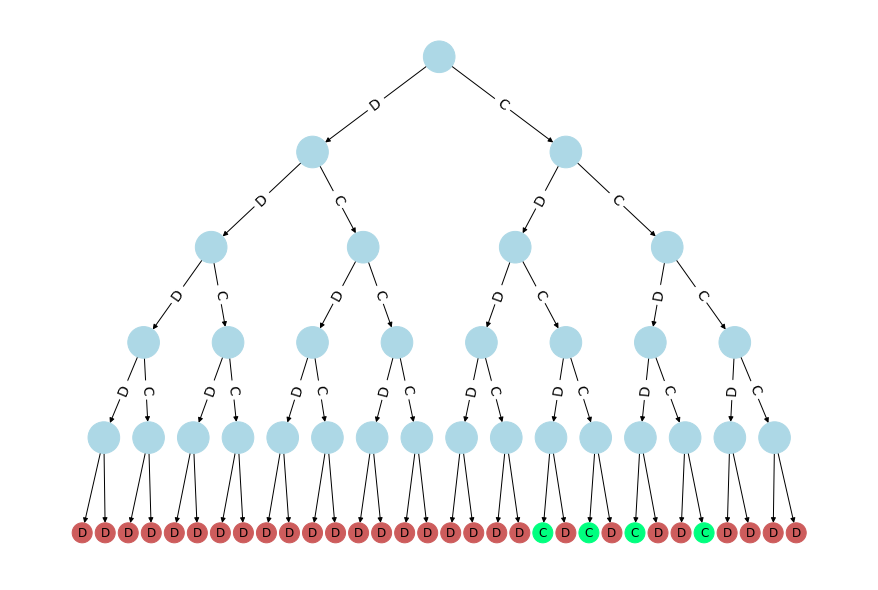

[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0]


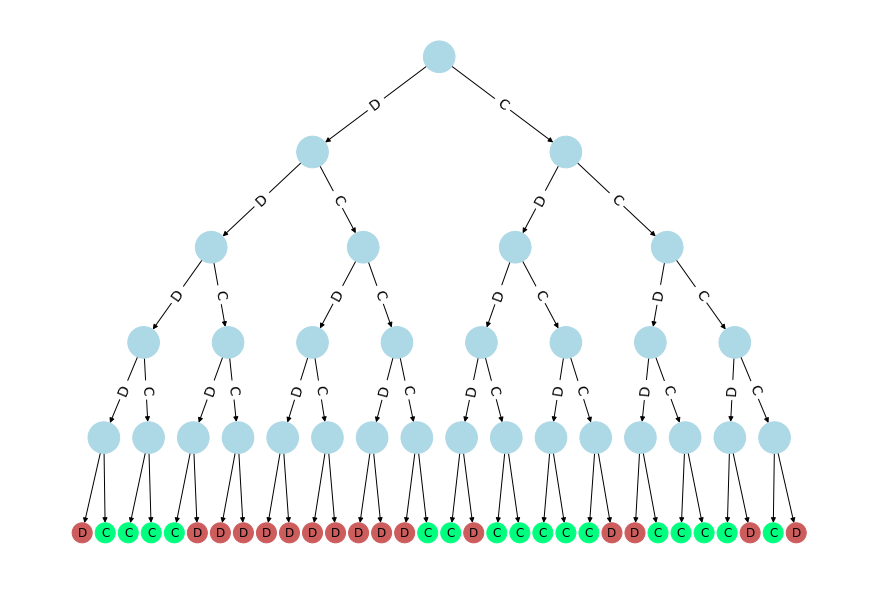

[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]


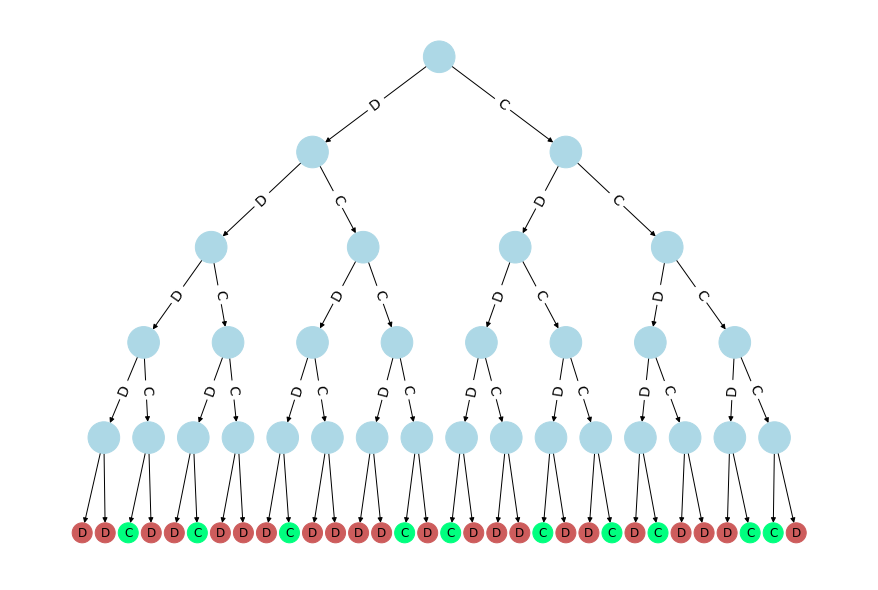

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


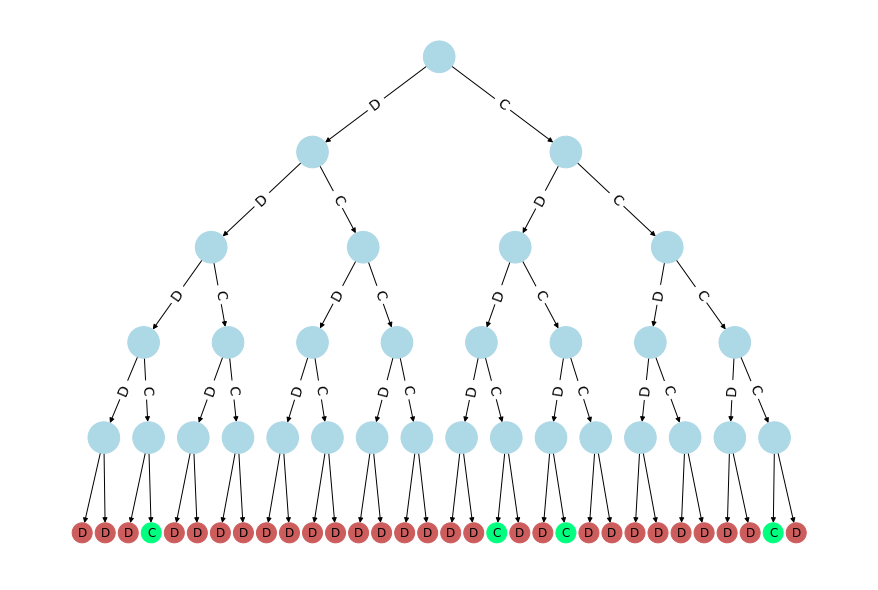

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


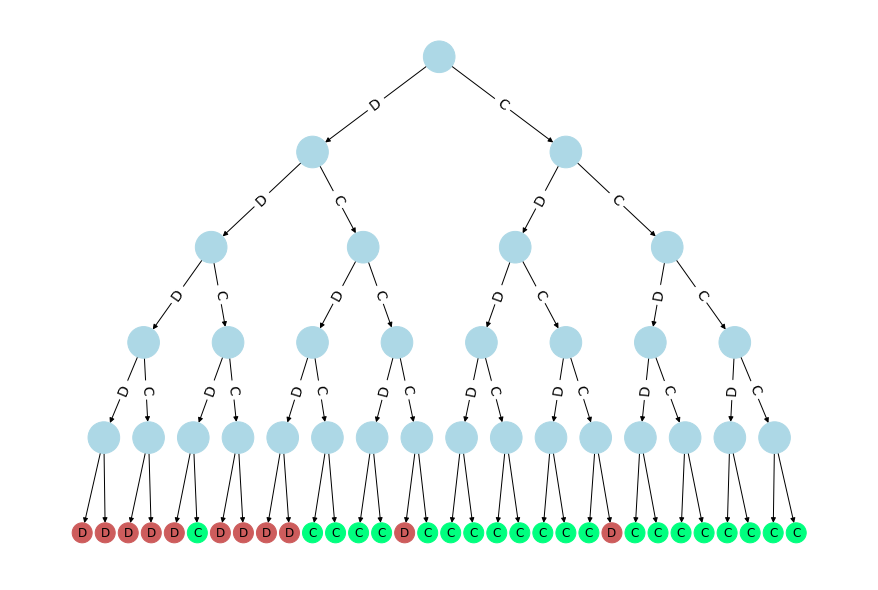

[0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


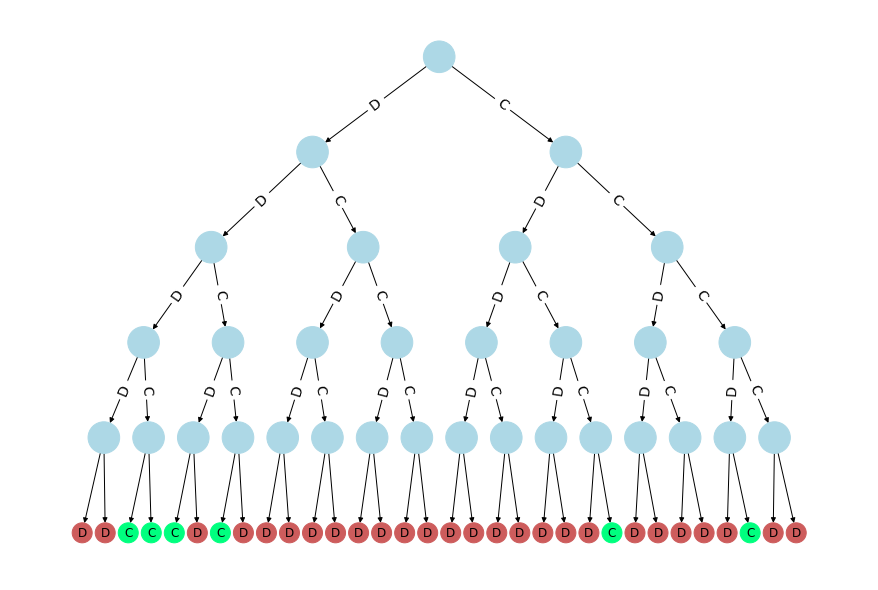

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


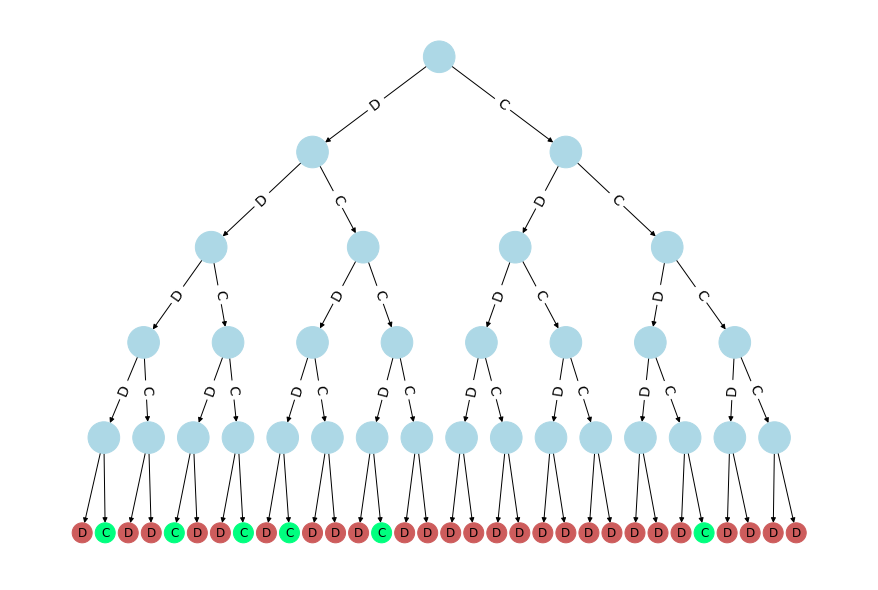

In [87]:
for best_result in results2:
    best_strategy = best_result['strategy']
    print(best_strategy)
    binary_tree_plot(best_strategy)

In [88]:
"""
ADDING NOISE TO DECISIONS
"""

def flip(bit):
    return (bit + 1) % 2


In [129]:
"""
CHANGED GENETIC ALGORITHM COMPONENTS

• Consider the introduction of noise
"""

def strat(prisoner, seqSelf, seqOpp, memory_length, noise_rate): # return 1 for cooperate OR 0 for defect
    
    game_length = len(seqSelf)
    
    if game_length < memory_length: 
        
        if game_length == 0: # what to do on the first move
            choice = prisoner[0] # predefined first move

        else: # what to do before game is the length of the memory of the agents
            choice_remainders = list(range(2**(memory_length - game_length)))

            count = 0
            base = 1
            for i in range(game_length):
                base += (seqOpp[i] * (2**(memory_length - game_length)))
                count += 1

            choices = [base + remainder for remainder in choice_remainders]
            total_cooperations = sum(prisoner[choice] for choice in choices)

            if total_cooperations < 2**(memory_length - game_length - 1):
                choice = 0
            else:
                choice = 1

    else:
        count = 0
        move_index = 1
        while count < memory_length:
            move_index += (seqOpp[-memory_length + count] * (2**(memory_length - count - 1)))
            count += 1
        choice = prisoner[move_index]
        
    if random.random() < noise_rate:
        return flip(choice)
    else:
        return choice
    
    
def fitness(prisoner, n, pop, noise_rate):
    
    opponents = random.sample(pop, len(pop)//10)
    
    sum_payoff = 0
    
    for opponent in opponents:
        payoff, opp_payoff = iterated_dilemma(prisoner, opponent, n, noise_rate)
        sum_payoff += payoff
                
    average_payoff = sum_payoff/len(opponents) # average payoff against fixed strategies
    expected_payoff = average_payoff/n # expected payoff for prisoner for any iteration
    return expected_payoff 


def tournament_selection(pop, n=20, k=2, tournament_size=4, noise_rate=0.1):
    
    selection = []
    
    for individual in range(k):
        candidates = random.sample(pop, tournament_size)
        best = max(candidates, key=lambda candidate: fitness(candidate, n, pop, noise_rate))
        selection.append(best)
        
    return tuple(selection)
    
    
def iterated_dilemma(prisonerA, prisonerB, n, noise_rate):
    
    memoryA, memoryB = int(math.log2(len(prisonerA) - 1)), int(math.log2(len(prisonerB) - 1)) # memory length of each prisoner
    seqA, seqB = [], [] # sequence of moves for each prisoner
    payoffA, payoffB = 0, 0 # payoff for each prisoner

    for i in range(n): # number of iteration of the dilemma
        
        # move for each prisoner
        moveA = strat(prisonerA, seqA, seqB, memoryA, noise_rate)
        moveB = strat(prisonerB, seqB, seqA, memoryB, noise_rate)
        
        # adds the move to the sequence of previous moves for each prisoner
        seqA.append(moveA)
        seqB.append(moveB)
        
        # calculates once-off pay-off for each prisoner based on move
        if moveA and moveB:
            scoreA, scoreB =  payoff_matrix[0][0]
        elif moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[0][1]
        elif not moveA and moveB:
            scoreA, scoreB =  payoff_matrix[1][0]
        elif not moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[1][1]
        
        # adds once-off pay-off to total pay-off for each prisoner
        payoffA += scoreA
        payoffB += scoreB
        
    return payoffA, payoffB


def run_genetic_algorithm(population_size, num_iterations, memory_length, num_generations,
                          crossover_function, mutation_function, mutation_rate, noise_rate):
    
    # features to track
    gen_count = 0
    gen_counts = []
    gen_best_fitnesses = []
    gen_best_strategies = []
    gen_mean_fitnesses = []
    gen_min_fitnesses = []
    gen_times = []
    
    pop = random_pop(population_size, memory_length) # initialises population
    best_strategy = pop[0]
    best_fitness = fitness(best_strategy, num_iterations, pop, noise_rate)
        
    no_improvement_count = 0 # counter to stop the code if we get 5 generations without improvement
    prev_best_fitness = float('inf')
    prev_mean_fitness = float('inf')


    for generation in range(num_generations):
        
        start_time = time.time() # starts timer
        
        fitnesses = [fitness(prisoner, num_iterations, pop, noise_rate) for prisoner in pop] # calculates individuals fitnesses
        new_pop = []

        while len(new_pop) < population_size: # assigns new individuals to the population for next generation
            
            parent1, parent2 = tournament_selection(pop, num_iterations, 2, 4, noise_rate) # tournament selection for choosing parents
                        
            # applying crossover operator to create children
            child1, child2 = crossover_function(parent1, parent2)
                
            # random chance of mutation
            if random.random() < mutation_rate:
                child1 = mutation_function(child1)
                    
            # independent random chance of the second child mutating        
            if random.random() < mutation_rate:
                child2 = mutation_function(child2)

            new_pop.append(child1)
            new_pop.append(child2)
                        
        pop = new_pop # assigns the new generation to be the current generation
            
        # calculating results for the current generation
        gen_count = gen_count + 1
        gen_best_fitness = max(fitnesses)
        gen_best_strategy = pop[fitnesses.index(gen_best_fitness)]
        gen_mean_fitness = sum(fitnesses) / population_size
        gen_min_fitness = min(fitnesses)
        gen_time = time.time() - start_time # ends timer
        
        # updates best strategy if new best is found
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_strategy = pop[fitnesses.index(gen_best_fitness)]
        
        # adds results
        gen_counts.append(gen_count)
        gen_best_fitnesses.append(gen_best_fitness)
        gen_best_strategies.append(gen_best_strategy)
        gen_mean_fitnesses.append(gen_mean_fitness)
        gen_min_fitnesses.append(gen_min_fitness)
        gen_times.append(gen_time)
        
        # if theres no improvement of the best generation fitness
        if gen_best_fitness <= prev_best_fitness:
            no_improvement_count = no_improvement_count + 1
        else:
            no_improvement_count = 0
        
        # stops the evolution algorithm if no improvement in 5 generations
        if no_improvement_count >= 10:
            break

        prev_best_fitness = gen_best_fitness
    
    # dictionary for results
    implementation_data = {
        "gen_counts": gen_counts,
        "gen_best_strategies": gen_best_strategies,
        "gen_best_fitnesses": gen_best_fitnesses,
        "gen_mean_fitnesses": gen_mean_fitnesses,
        "gen_min_fitnesses": gen_min_fitnesses,
        "gen_compute_time": gen_times
    }
        
    return implementation_data, best_strategy, pop


In [139]:
# DEFINING HYPERPARAMETERS TO BE USED

population_sizes = [100]
memory_lengths = [5]
crossover_operators = [mid_point_crossover]
mutation_operators = [inverse_mutation]
mutation_rates = [0.18]
noise_rates = [0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2]

# GRID SEARCH ALL HYPERPARAMETER COMBINATIONS

results3 = []
for crossover_operator in crossover_operators:
    for mutation_operator in mutation_operators:
        for mutation_rate in mutation_rates:
            for noise_rate in noise_rates:

                start_time = time.time()
                result, best_strategy, final_pop = run_genetic_algorithm(population_sizes[0], 40, memory_lengths[0], 40,
                                                          crossover_operator, mutation_operator, mutation_rate, noise_rate)
                time_taken = round(time.time()-start_time)
                print("Noise Rate =", noise_rate, "\nBest Strategy =", best_strategy, "\nFitness =", fitness(best_strategy, 40, final_pop, noise_rate),
                      "\nTime Taken = ", time_taken, "seconds\n")

                results3.append({
                    'strategies': result['gen_best_strategies'],
                    'best fitness per generation': result['gen_best_fitnesses'],
                    'mean fitness per generation': result['gen_mean_fitnesses'],
                    'population_size': population_size,
                    'memory_length': memory_length,
                    'crossover': crossover_operator,
                    'mutation': mutation_operator,
                    'mutation rate': mutation_rate,
                    'noise rate': noise_rate
                })

Crossover Operator = mid_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.18 
Noise Rate = 0.02
Best Strategy = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1] 
Fitness = 1.7850000000000001 
Time Taken =  47 seconds

Crossover Operator = mid_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.18 
Noise Rate = 0.04
Best Strategy = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0] 
Fitness = 2.525 
Time Taken =  46 seconds

Crossover Operator = mid_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.18 
Noise Rate = 0.06
Best Strategy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
Fitness = 1.4725 
Time Taken =  46 seconds

Crossover Operator = mid_point_crossover 
Mutation Operator = inverse_mutation 
Mutation Rate = 0.18 
Noise Rate = 0.08
Best Strategy = [1, 0, 1, 

In [140]:
def plot(results, param, fitness_type, jitter=0):
    
    colours = ["red", "blue", "green", "purple", "orange", "cyan", "magenta"]

    plt.figure(figsize=(12, 10))
    plt.title(f"Comparing {param}", fontsize=22)
    plt.xlabel("Generation", fontsize=20)
    plt.ylabel(f"{fitness_type}", fontsize=20)
    
    param_values = []
    colour_map = {}
    colour_legend = {}

    for result in results:
        
        param_value = result[param]
        
        if param_value not in param_values:
            param_values.append(param_value)
            colour_map[param_value] = colours[len(param_values) - 1]  # Assign colours in order
        
        best_fitness = result[fitness_type]
        generations = range(len(best_fitness))
        
        if jitter:
            jitter_amount = random.uniform(-jitter, jitter)
            best_fitness_j = [f + jitter_amount for f in best_fitness]
        else:
            best_fitness_j = best_fitness
            
        colour = colour_map[param_value] 
        
        if colour not in colour_legend:
            if callable(result[param]):
                colour_legend[colour] = f"{param} = {result[param].__name__}"
            else:
                colour_legend[colour] = f"{param} = {result[param]}"

        plt.plot(generations, best_fitness_j, color=colour)

    legend_handles = [plt.Line2D([0], [0], color=colour, label=label) for colour, label in colour_legend.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=18)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
        
    plt.grid(True)
    plt.show()

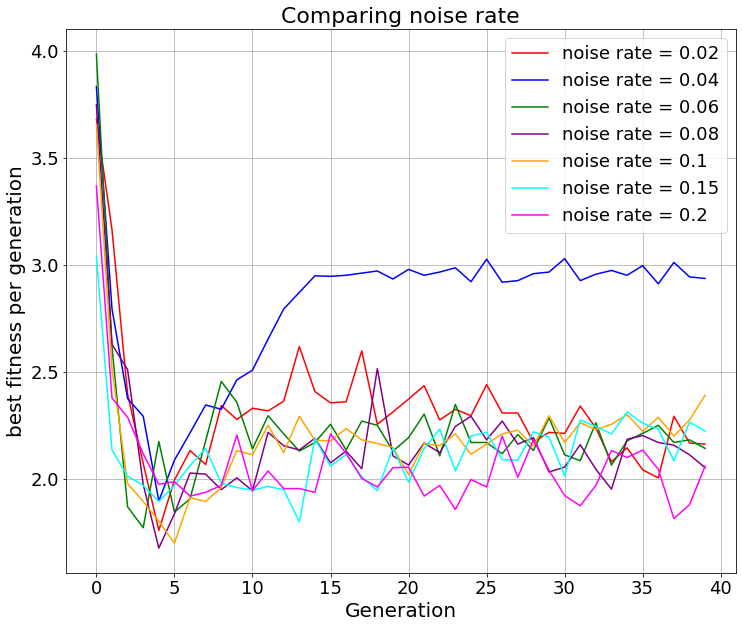

In [141]:
# Plotting best population fitness over generations

plot(results3, 'noise rate', 'best fitness per generation')

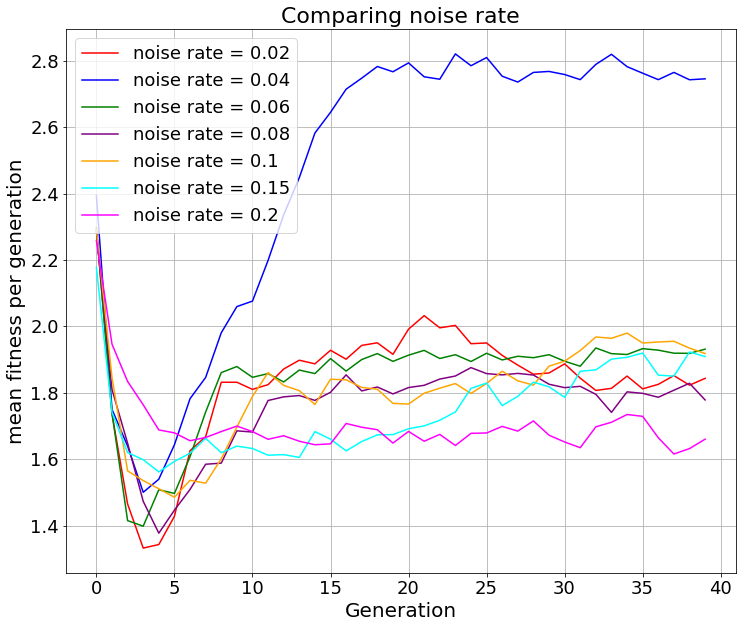

In [142]:
# Plotting mean population fitness over generations

plot(results3, 'noise rate', 'mean fitness per generation')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


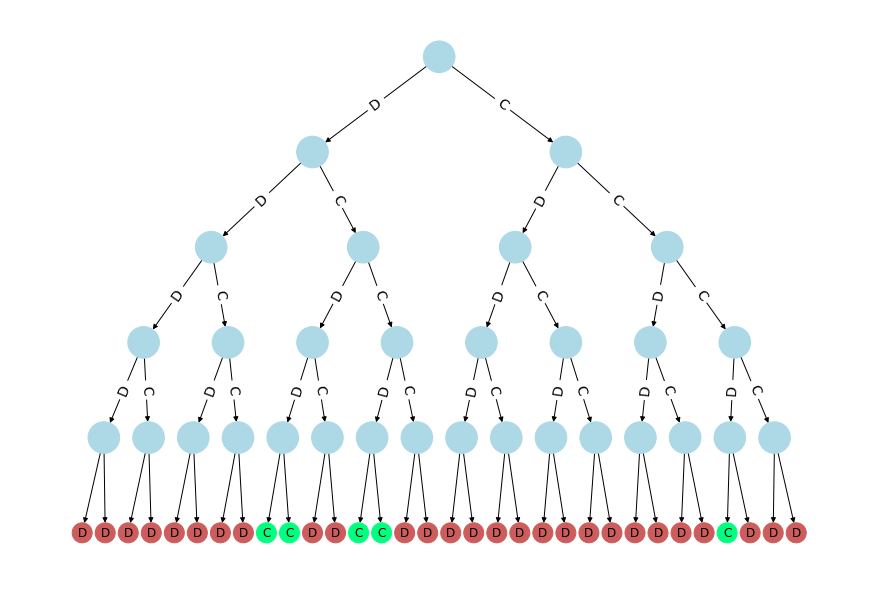

[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


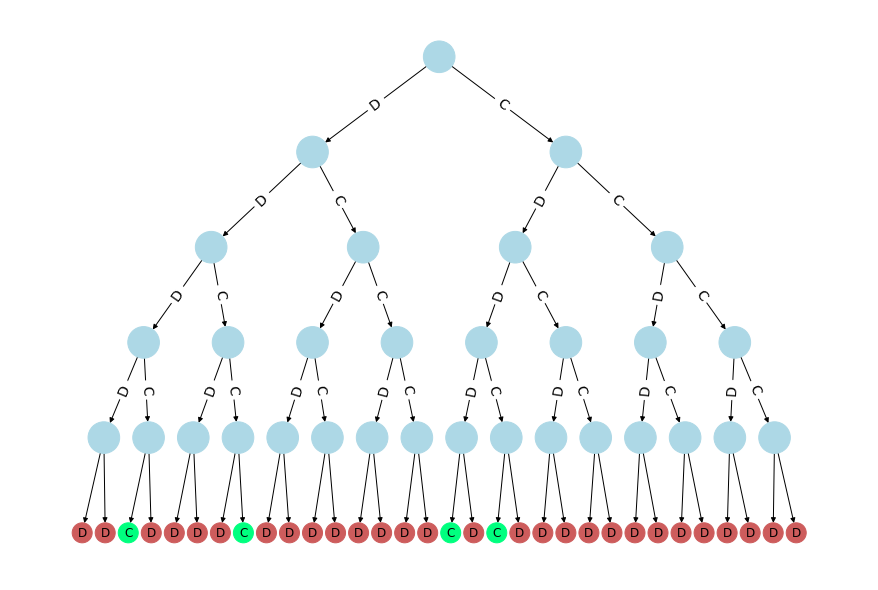

[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


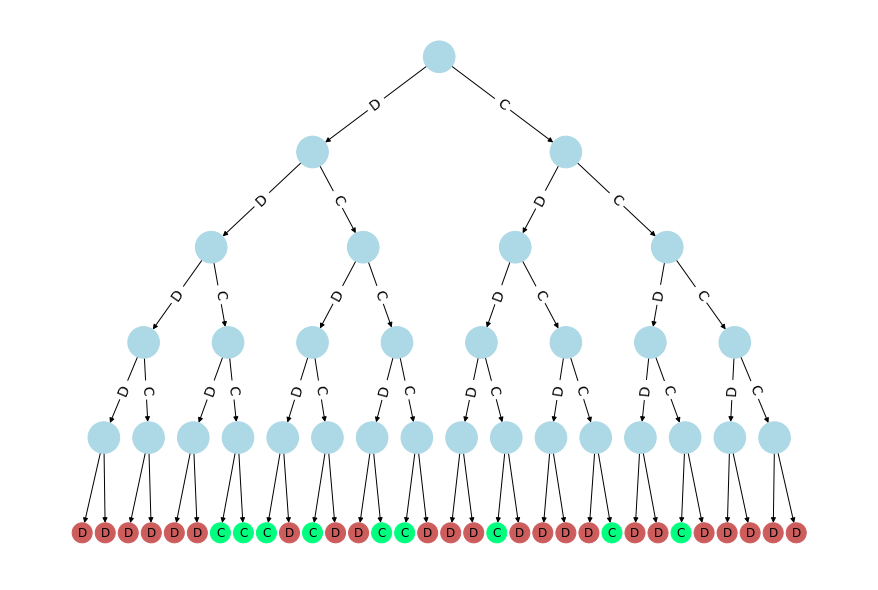

[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


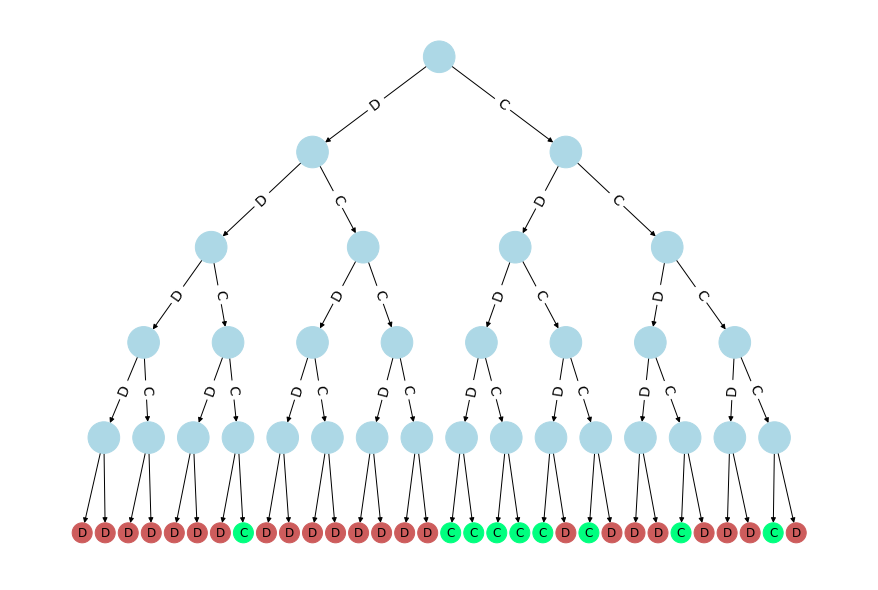

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]


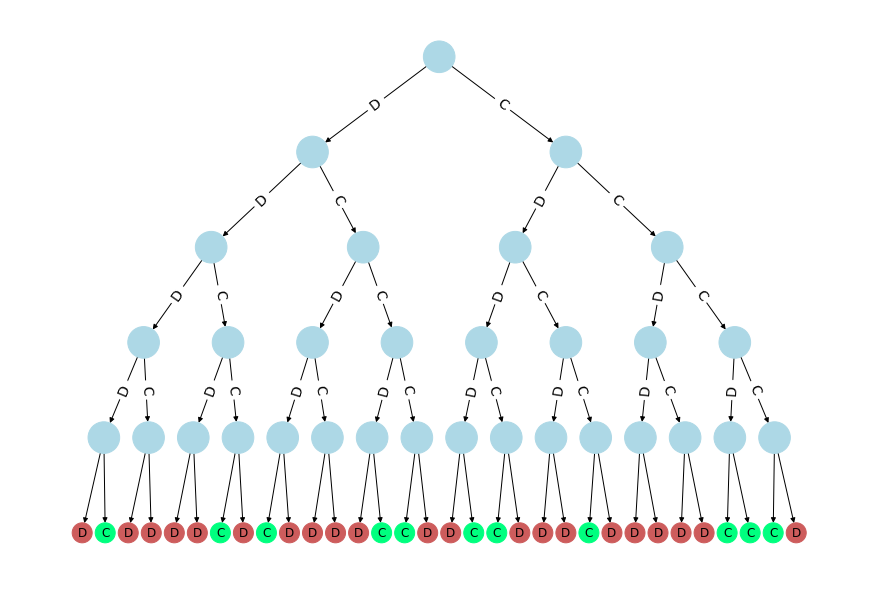

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


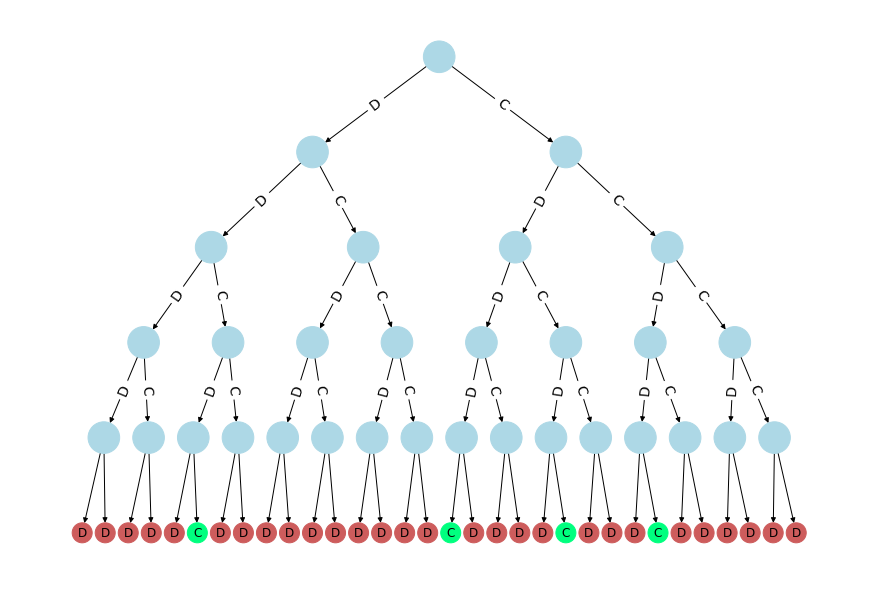

[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0]


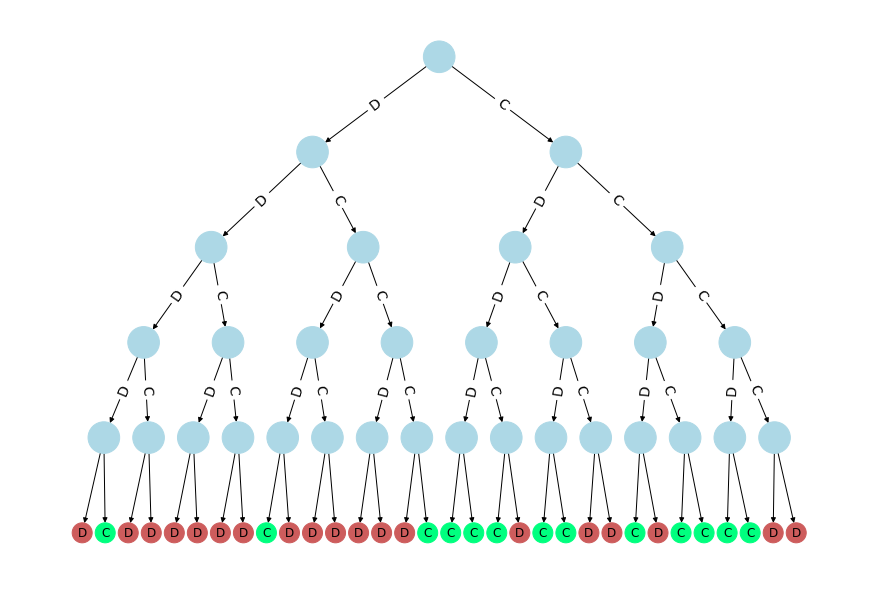

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


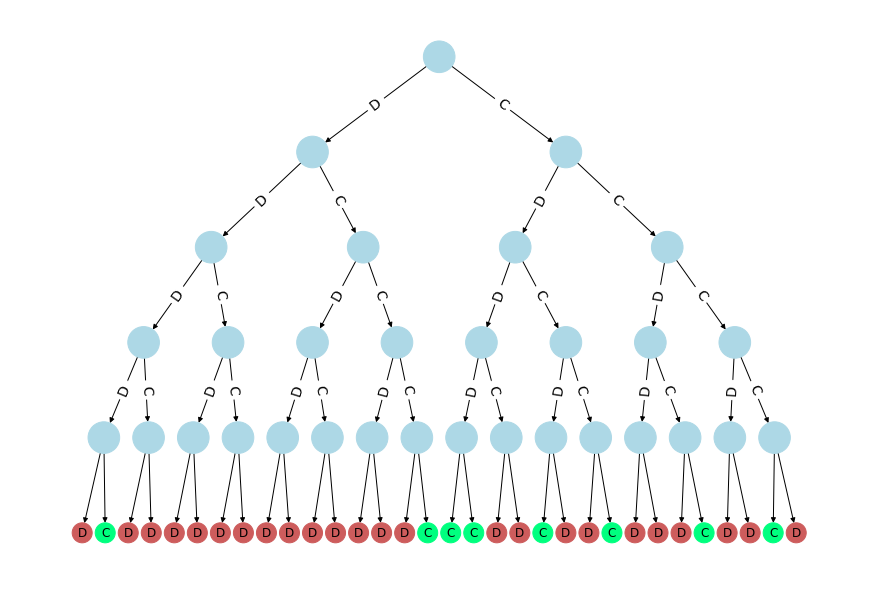

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


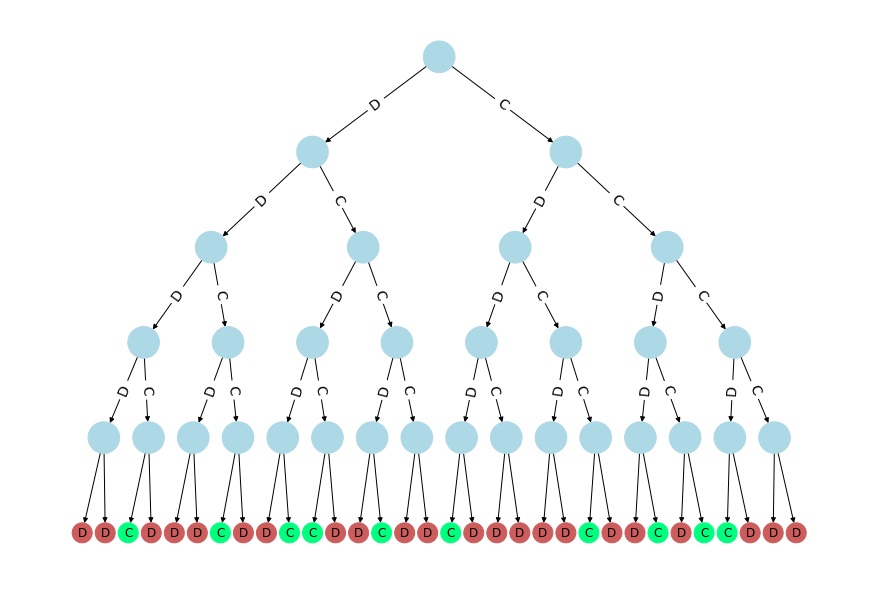

[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]


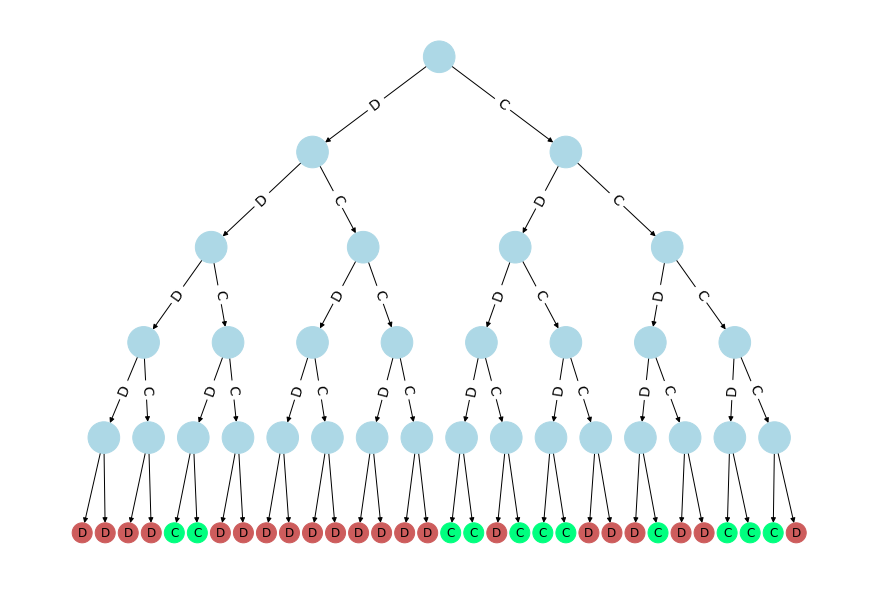

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


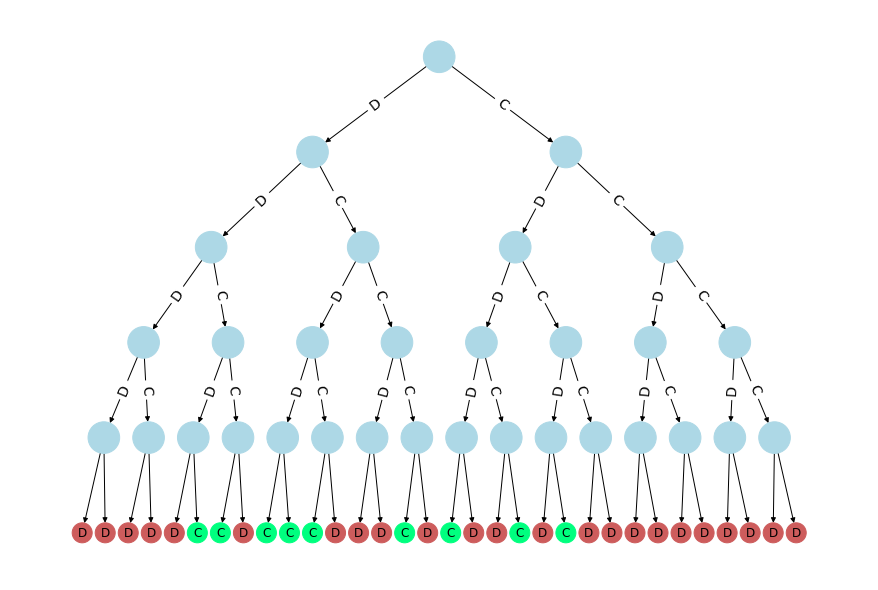

[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]


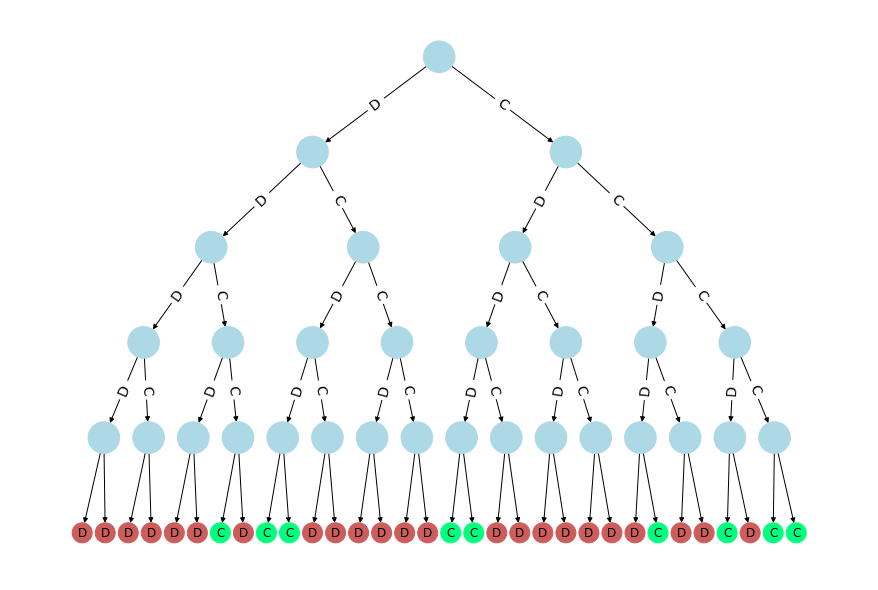

[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


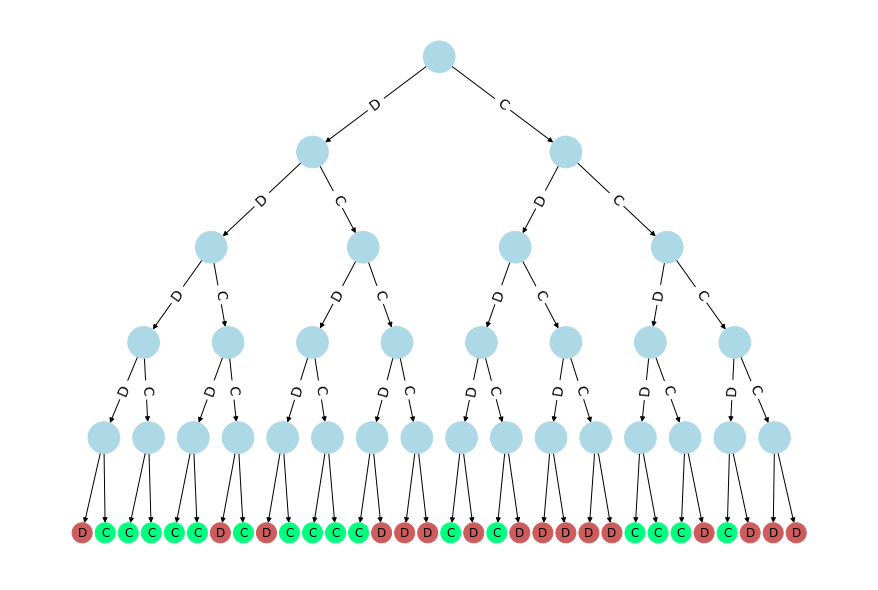

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]


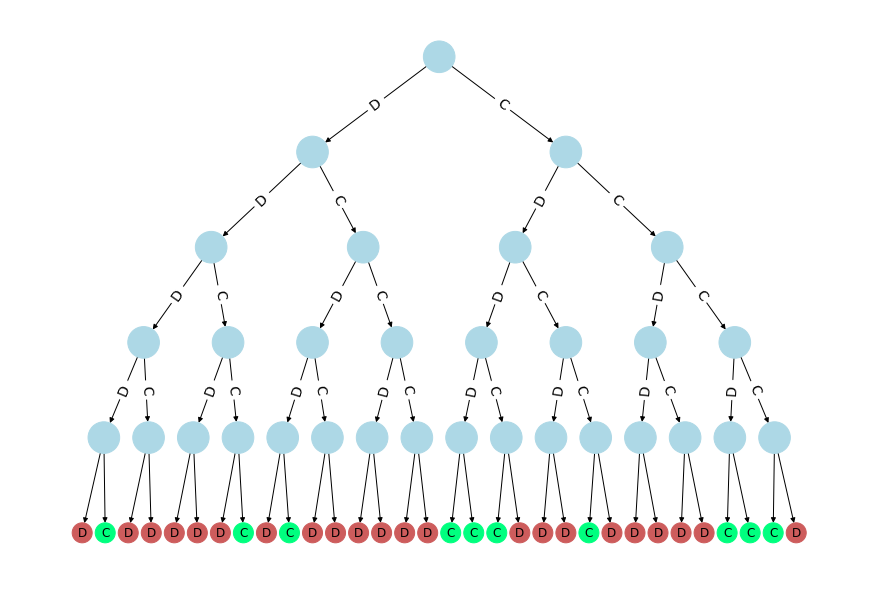

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]


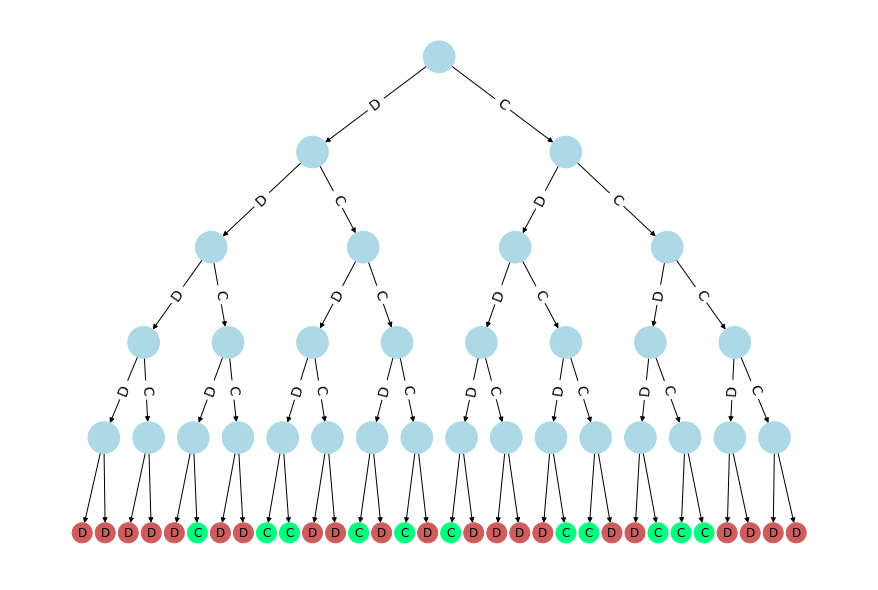

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]


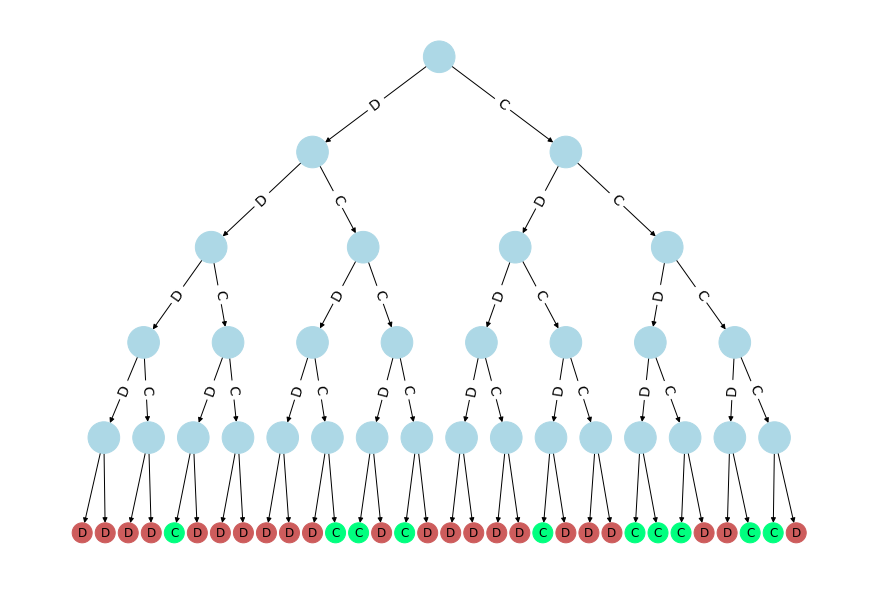

In [98]:
for best_result in results3:
    best_strategy = best_result['strategy']
    print(best_strategy)
    binary_tree_plot(best_strategy)